In [1]:
#Importando bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from ipywidgets import interact, interactive, fixed, interact_manual
#from utils import *

#import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

In [61]:
def plot_well_logs_comparison(df, well,lithology_col,predicted_col,colors,lithology,dz=100,figsize=(11,12)):
    fig, axes = plt.subplots(1, 6, figsize=figsize)

    # Definindo o limite vertical e adicionando grade
    for ax in axes:
        ax.set_ylim(df[df.WELL == well].DEPTH_MD.max() + dz, df[df.WELL == well].DEPTH_MD.min() - dz)
        ax.grid()

    # Primeiro gráfico: GR com CALI
    axes[0].plot(df[df.WELL == well].GR, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='GR')
    ax0 = axes[0].twiny()
    ax0.plot(df[df.WELL == well].CALI, df[df.WELL == well].DEPTH_MD, c='r', ls='--', lw=0.8, label='CALI')
    ax0.legend(loc='upper left', fontsize=8)

    # Segundo gráfico: RDEP e RMED
    axes[1].plot(df[df.WELL == well].RDEP, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='RILD')
    axes[1].plot(df[df.WELL == well].RMED, df[df.WELL == well].DEPTH_MD, color='red', lw=0.8, label='RILM', ls='--')
    axes[1].set_xscale('log')

    # Terceiro gráfico: DTC
    axes[2].plot(df[df.WELL == well].DTC, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='DTC')

    # Quarto gráfico: RHOB com NPHI
    axes[3].plot(df[df.WELL == well].RHOB, df[df.WELL == well].DEPTH_MD, color='blue', lw=0.8, label='RHOB')
    ax3 = axes[3].twiny()
    ax3.plot(df[df.WELL == well].NPHI, df[df.WELL == well].DEPTH_MD, color='red', lw=0.8, label='NPHI', ls='--')


    for i,j in zip(lithology,colors):

        axes[4].fill_betweenx(df[df.WELL == well].DEPTH_MD, 0,
                           1, 
                           where=(df[df.WELL == well][lithology_col] == i), 
                           color=j, alpha=1,label=i)
        
    for i,j in zip(lithology,colors):

        axes[5].fill_betweenx(df[df.WELL == well].DEPTH_MD, 0,
                           1, 
                           where=(df[df.WELL == well][predicted_col]== i), 
                           color=j, alpha=1,label=i)

    # Adicionando legendas em todos os gráficos
    for ax in axes:
        ax.legend(fontsize=8, loc='upper right')

    axes[4].legend(fontsize=5)
    axes[5].legend(fontsize=5)

    # Ajustando o layout para evitar sobreposição
    fig.tight_layout()

    return fig, axes

In [2]:
colors = [
    "#fcf444",  # light yellow/pastel yellow
    "#84fc04",  # lime green / neon green
    "#84b4b4",  # blue-green
    "#340cfc",  # deep blue / electric blue
    "#046ccc",  # cyan blue
    "#c0fcfc",  # light cyan
    "#88fcfc",  # very light cyan / soft turquoise
    "#6cb4cc",  # light sky blue / light cerulean blue
    "#dc1cfc",  # bright magenta / electric purple
    "#1005bc",  # deep blue
    "#dedede",  # light gray
    "#fc0c34"   # gainsboro
]

lithology = [
    "Sandstone (Arenito)",
    "Sandstone/Shale (Arenito)",
    "Shale (Argilito)",
    "Marl (Marga)",
    "Dolomite (Dolomita)",
    "Limestone (Calcário)",  
    "Chalk (Giz)",
    "Halite (Halita)",
    "Anhydrite (Anidrita)",
    "Tuff (Tufo)",
    "Coal (Carvão)",
    "Basement (Substrato)" 
]

litologia_dict = {
    30000: 'Sandstone (Arenito)',
    65030: 'Sandstone/Shale (Arenito/Argilito)',
    65000: 'Shale (Argilito)',
    80000: 'Marl (Marga)',
    74000: 'Dolomite (Dolomita)',
    70000: 'Limestone (Calcário)',
    70032: 'Chalk (Giz)',
    88000: 'Halite (Halita)',
    86000: 'Anhydrite (Anidrita)',
    99000: 'Tuff (Tufo)',
    90000: 'Coal (Carvão)',
    93000: 'Basement (Substrato)'
}

In [3]:
dataset = pd.read_csv('train_dataset_proc.csv',index_col=0)
dataset.head()

,WELL,DEPTH_MD,CALI,RMED,RDEP,RHOB,GR,NPHI,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY,GROUP,GROUP_num,LITHOLOGY,RMED_log,RDEP_log
4238,15/9-13,1138.704,19.322735,1.013309,1.091499,1.774626,55.892757,0.765867,147.837677,30000,NORDLAND GP.,6,Sandstone (Arenito),0.005742,0.038023
4239,15/9-13,1138.856,18.613674,1.088184,1.122706,1.800986,60.929138,0.800262,142.382431,65000,NORDLAND GP.,6,Shale (Argilito),0.036703,0.050266
4240,15/9-13,1139.008,18.212072,1.127155,1.148141,1.817696,62.117264,0.765957,138.258331,65000,NORDLAND GP.,6,Shale (Argilito),0.051984,0.059995
4241,15/9-13,1139.160,18.134182,1.141467,1.170984,1.829333,61.010860,0.702521,139.198914,65000,NORDLAND GP.,6,Shale (Argilito),0.057463,0.068551
4242,15/9-13,1139.312,18.033762,1.138007,1.184080,1.813854,58.501236,0.639708,144.290085,65000,NORDLAND GP.,6,Shale (Argilito),0.056145,0.073381


In [5]:
blind = pd.read_csv('blind_dataset_proc.csv',index_col=0)
blind.head()

,WELL,DEPTH_MD,CALI,RMED,RDEP,RHOB,GR,NPHI,DTC,FORCE_2020_LITHOFACIES_LITHOLOGY,GROUP,GROUP_num,LITHOLOGY,RMED_log,RDEP_log
273022,25/5-1,2905.776,12.466360,1.825007,1.427828,2.329974,119.460960,0.563507,122.080429,65000,VIKING GP.,11,Shale (Argilito),0.261265,0.154676
273023,25/5-1,2905.928,12.403155,1.868067,1.418406,2.322307,85.754578,0.552818,122.151680,65000,VIKING GP.,11,Shale (Argilito),0.271392,0.151801
273024,25/5-1,2906.080,12.415901,1.840098,1.431611,2.289036,68.701172,0.548537,122.121925,65000,VIKING GP.,11,Shale (Argilito),0.264841,0.155825
273025,25/5-1,2906.232,12.507156,1.788438,1.436445,2.257969,70.682800,0.564075,122.014633,65000,VIKING GP.,11,Shale (Argilito),0.252474,0.157289
273026,25/5-1,2906.384,12.560205,1.768898,1.433732,2.247065,72.680580,0.586183,121.895653,65000,VIKING GP.,11,Shale (Argilito),0.247703,0.156468


In [6]:
#Verificando as colunas do dataset
dataset.columns

Index(['WELL', 'DEPTH_MD', 'CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC',
       'FORCE_2020_LITHOFACIES_LITHOLOGY', 'GROUP', 'GROUP_num', 'LITHOLOGY',
       'RMED_log', 'RDEP_log'],
      dtype='object')

In [11]:
#Separando as variáveis de entrada e saída
cols = ['CALI', 'RMED', 'RDEP', 'RHOB', 'GR', 'NPHI', 'DTC'
        , 'GROUP_num', 'RMED_log', 'RDEP_log']

X = dataset[cols]
y = dataset['FORCE_2020_LITHOFACIES_LITHOLOGY']

In [12]:
#Separando conjunto de treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler()

In [14]:
#média e desvio padrão salvo
scaler.mean_,scaler.var_

(array([ 12.26376475,   4.73998568,   4.62338421,   2.33341878,
         72.70634117,   0.34438321, 105.85313853,   6.45130506,
          0.33735659,   0.30704504]),
 array([1.05771483e+01, 7.93866547e+02, 1.28140252e+03, 5.99846463e-02,
        1.14976990e+03, 1.78801186e-02, 8.07053130e+02, 9.89016766e+00,
        1.84996726e-01, 1.72171265e-01]))

### Experimentos com a regressão logística

In [15]:
lr = LogisticRegression()
lr.fit(scaler.transform(X_train),y_train)

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [16]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_train,lr.predict(scaler.transform(X_train)),
                            target_names=litologia_dict.values()))

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.69      0.69      0.69     38458
Sandstone/Shale (Arenito/Argilito)       0.82      0.97      0.89    187123
                  Shale (Argilito)       0.50      0.11      0.18     30161
                      Marl (Marga)       0.55      0.54      0.55     14306
               Dolomite (Dolomita)       0.46      0.30      0.36      3302
              Limestone (Calcário)       0.00      0.00      0.00       564
                       Chalk (Giz)       0.58      0.18      0.27      8835
                   Halite (Halita)       0.87      0.86      0.86       167
              Anhydrite (Anidrita)       0.00      0.00      0.00        16
                       Tuff (Tufo)       0.66      0.47      0.55      1646
                     Coal (Carvão)       0.86      0.49      0.63        75
              Basement (Substrato)       0.00      0.00      0.00      2153

          

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
print(classification_report(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],lr.predict(scaler.transform(blind[cols]))))

              precision    recall  f1-score   support

       30000       0.76      0.72      0.74      7483
       65000       0.57      0.95      0.72      9785
       65030       0.47      0.02      0.04      4896
       70000       0.88      0.05      0.09      1645
       70032       0.75      1.00      0.86      2041
       74000       0.00      0.00      0.00        15
       80000       0.00      0.00      0.00       404
       90000       0.67      0.30      0.42       191

    accuracy                           0.64     26460
   macro avg       0.51      0.38      0.36     26460
weighted avg       0.63      0.64      0.56     26460



c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Acer3\AppData\Local\Temp\ipykernel_9812\1248277359.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


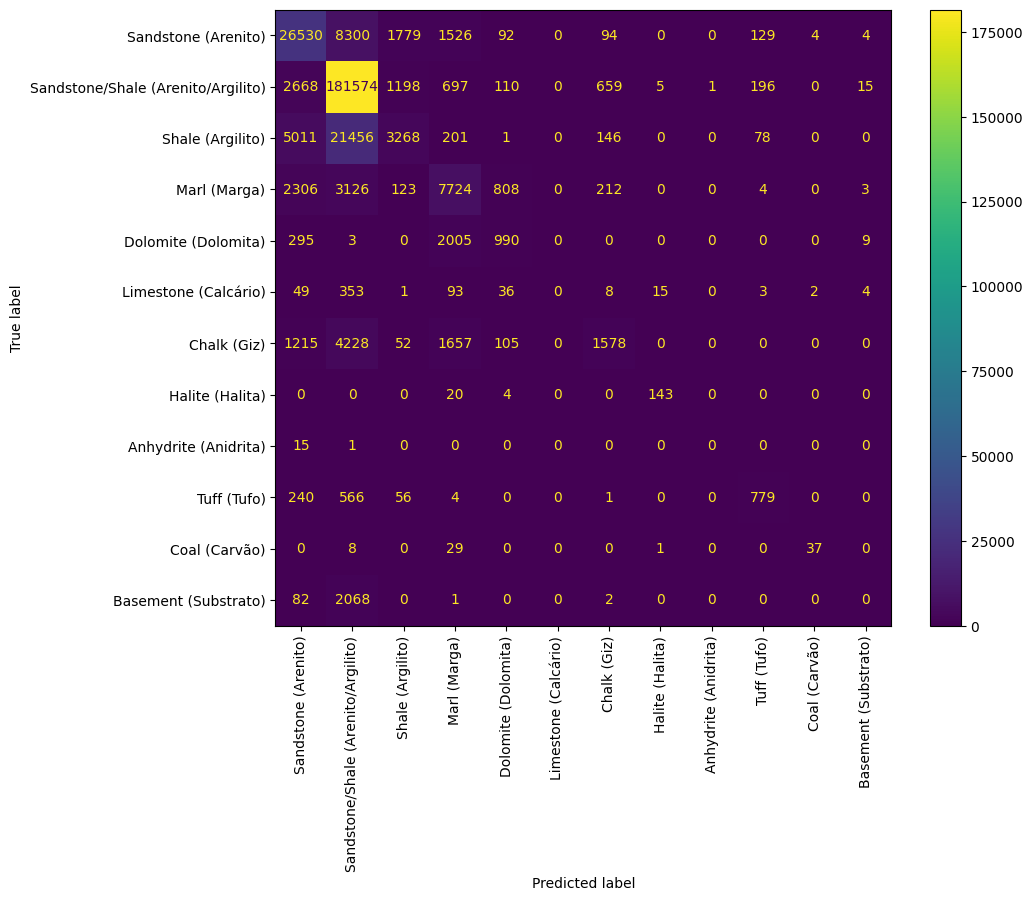

In [18]:
#Plotando a matriz de confusão

fig,axes = plt.subplots(figsize=(10,8))

disp = ConfusionMatrixDisplay(confusion_matrix(y_train,lr.predict(scaler.transform(X_train))),
                              display_labels=litologia_dict.values())

disp.plot(ax=axes)

axes.set_xticklabels(litologia_dict.values(),rotation=90)

fig.show()

In [19]:
#usando o map para transform as labels em strings
dataset['log_reg'] = list(map(litologia_dict.get,lr.predict(scaler.transform(X))))
blind['log_reg'] = list(map(litologia_dict.get,lr.predict(scaler.transform(blind[cols]))))

In [21]:
@interact(well=blind.WELL.unique())
def update_well_plot(well):
    plot_well_logs_comparison(blind, well=well,lithology_col='LITHOLOGY',predicted_col='log_reg',colors=colors,lithology=lithology,dz=100)

interactive(children=(Dropdown(description='well', options=('25/5-1', '25/9-1', '31/4-5', '35/11-1', '7/1-1'),…

### Aplicando o KNN

In [22]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(scaler.transform(X_train),y_train)

KNeighborsClassifier(n_neighbors=7)

In [28]:
y_knn_pred = knn.predict(scaler.transform(X_train))
y_knn_pred_test = knn.predict(scaler.transform(X_test))

In [29]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_train,y_knn_pred,
                            target_names=litologia_dict.values()))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.92      0.92      0.92     38458
Sandstone/Shale (Arenito/Argilito)       0.95      0.98      0.96    187123
                  Shale (Argilito)       0.85      0.80      0.82     30161
                      Marl (Marga)       0.93      0.79      0.85     14306
               Dolomite (Dolomita)       0.94      0.93      0.94      3302
              Limestone (Calcário)       0.81      0.38      0.52       564
                       Chalk (Giz)       0.90      0.86      0.88      8835
                   Halite (Halita)       0.86      0.86      0.86       167
              Anhydrite (Anidrita)       0.83      0.62      0.71        16
                       Tuff (Tufo)       0.90      0.72      0.80      1646
                     Coal (Carvão)       0.92      0.97      0.95        75
              Basement (Substrato)       0.87      0.82      0.84      2153

          

In [31]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_test,y_knn_pred_test,
                            target_names=litologia_dict.values()))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.88      0.89      0.89      9504
Sandstone/Shale (Arenito/Argilito)       0.94      0.97      0.95     46887
                  Shale (Argilito)       0.78      0.73      0.76      7531
                      Marl (Marga)       0.90      0.76      0.83      3573
               Dolomite (Dolomita)       0.91      0.90      0.90       830
              Limestone (Calcário)       0.70      0.27      0.39       121
                       Chalk (Giz)       0.86      0.79      0.82      2270
                   Halite (Halita)       0.84      0.85      0.85        48
              Anhydrite (Anidrita)       1.00      0.50      0.67         4
                       Tuff (Tufo)       0.87      0.71      0.78       391
                     Coal (Carvão)       0.81      0.87      0.84        15
              Basement (Substrato)       0.83      0.73      0.78       528

          

C:\Users\Acer3\AppData\Local\Temp\ipykernel_9812\3368134668.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


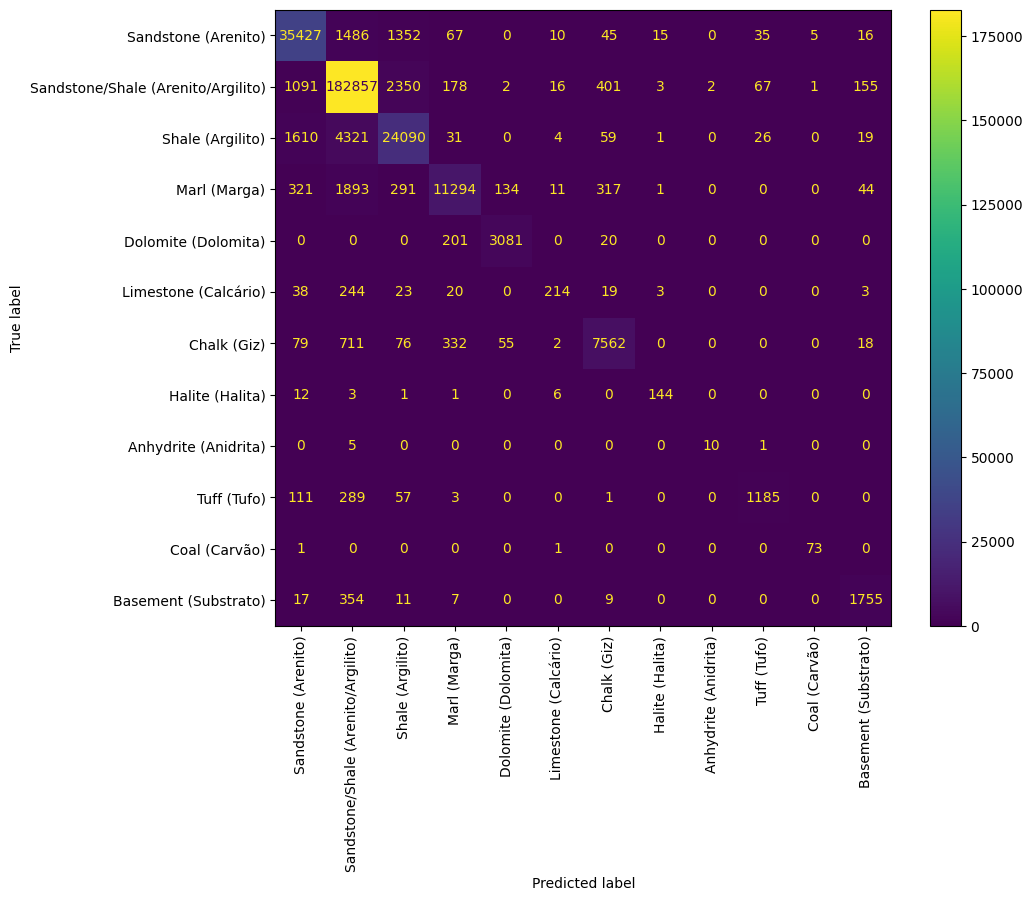

In [32]:
#Plotando a matriz de confusão

fig,axes = plt.subplots(figsize=(10,8))

disp = ConfusionMatrixDisplay(confusion_matrix(y_train,y_knn_pred),
                              display_labels=litologia_dict.values())

disp.plot(ax=axes)

axes.set_xticklabels(litologia_dict.values(),rotation=90)

fig.show()

In [33]:
y_blind = knn.predict(scaler.transform(blind[cols]))

In [34]:
keys_blind = sorted(np.unique(y_blind))
dic_blind = {chave: litologia_dict[chave] for chave in keys_blind}

In [35]:
litologia_dict

{30000: 'Sandstone (Arenito)',
 65030: 'Sandstone/Shale (Arenito/Argilito)',
 65000: 'Shale (Argilito)',
 80000: 'Marl (Marga)',
 74000: 'Dolomite (Dolomita)',
 70000: 'Limestone (Calcário)',
 70032: 'Chalk (Giz)',
 88000: 'Halite (Halita)',
 86000: 'Anhydrite (Anidrita)',
 99000: 'Tuff (Tufo)',
 90000: 'Coal (Carvão)',
 93000: 'Basement (Substrato)'}

In [39]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind,target_names=list(dic_blind.values())))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.82      0.58      0.68      7483
                  Shale (Argilito)       0.62      0.91      0.74      9785
Sandstone/Shale (Arenito/Argilito)       0.31      0.21      0.25      4896
              Limestone (Calcário)       0.31      0.53      0.39      1645
                       Chalk (Giz)       0.70      0.08      0.14      2041
               Dolomite (Dolomita)       0.00      0.00      0.00        15
                      Marl (Marga)       0.23      0.10      0.14       404
              Anhydrite (Anidrita)       0.00      0.00      0.00         0
                     Coal (Carvão)       0.58      0.38      0.46       191
                       Tuff (Tufo)       0.00      0.00      0.00         0

                          accuracy                           0.58     26460
                         macro avg       0.36      0.28      0.28     26460
          

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Acer3\AppData\Local\Temp\ipykernel_9812\3156860936.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


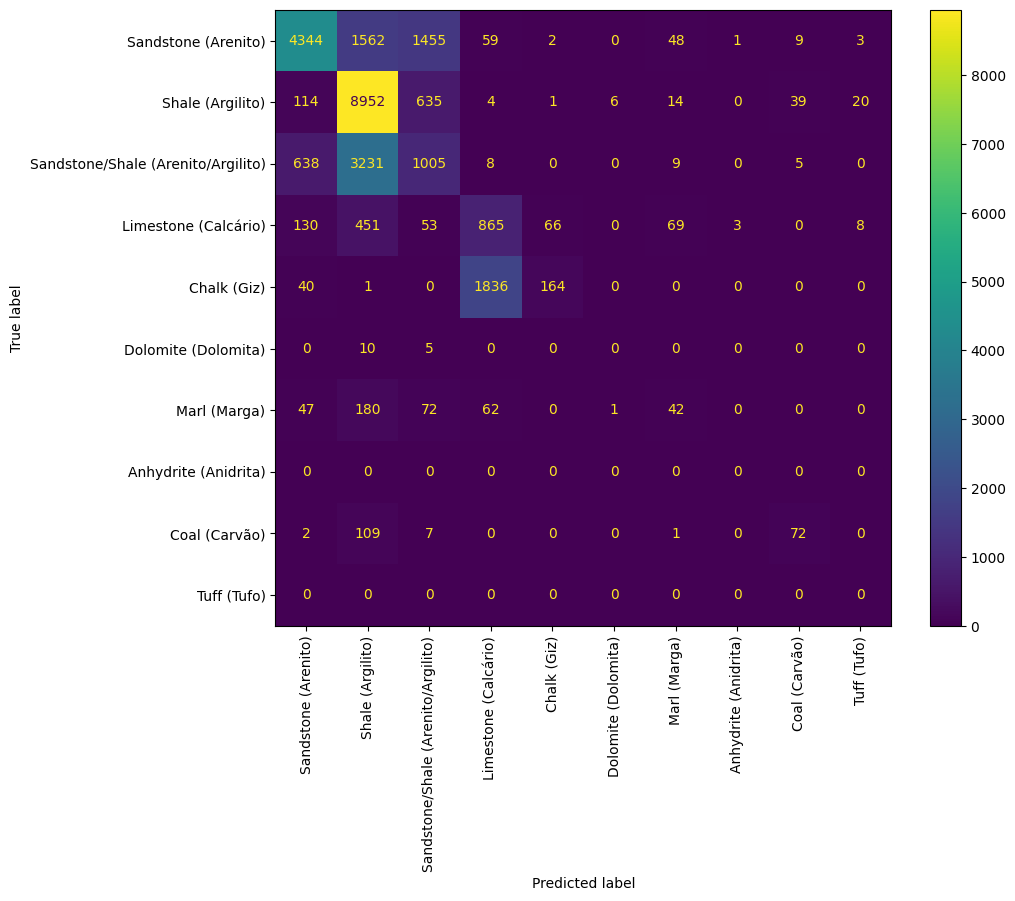

In [40]:
#Plotando a matriz de confusão

fig,axes = plt.subplots(figsize=(10,8))

disp = ConfusionMatrixDisplay(confusion_matrix(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind),
                              display_labels=list(dic_blind.values()))

disp.plot(ax=axes)

axes.set_xticklabels(dic_blind.values(),rotation=90)

fig.show()

In [38]:
#usando o map para transform as labels em strings
dataset['knn'] = list(map(litologia_dict.get,knn.predict(scaler.transform(X))))
blind['knn'] = list(map(litologia_dict.get,y_blind))

In [41]:
@interact(well=blind.WELL.unique())
def update_well_plot(well):
    plot_well_logs_comparison(blind, well=well,lithology_col='LITHOLOGY',predicted_col='knn',colors=colors,lithology=lithology,dz=100)

interactive(children=(Dropdown(description='well', options=('25/5-1', '25/9-1', '31/4-5', '35/11-1', '7/1-1'),…

In [42]:
mlp = MLPClassifier(alpha=0.001,activation='tanh',hidden_layer_sizes=(30,15,15),max_iter=200)

mlp.fit(scaler.transform(X_train),y_train)

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(activation='tanh', alpha=0.001, hidden_layer_sizes=(30, 15, 15))

In [43]:
y_mlp_pred = mlp.predict(scaler.transform(X_train))
y_mlp_pred_test = mlp.predict(scaler.transform(X_test))

In [44]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_train,y_mlp_pred,
                            target_names=litologia_dict.values()))

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.84      0.83      0.84     38458
Sandstone/Shale (Arenito/Argilito)       0.90      0.95      0.93    187123
                  Shale (Argilito)       0.63      0.56      0.59     30161
                      Marl (Marga)       0.84      0.66      0.74     14306
               Dolomite (Dolomita)       0.87      0.80      0.83      3302
              Limestone (Calcário)       0.50      0.01      0.01       564
                       Chalk (Giz)       0.73      0.58      0.65      8835
                   Halite (Halita)       0.84      0.93      0.88       167
              Anhydrite (Anidrita)       0.00      0.00      0.00        16
                       Tuff (Tufo)       0.75      0.59      0.66      1646
                     Coal (Carvão)       0.85      0.61      0.71        75
              Basement (Substrato)       0.64      0.48      0.55      2153

          

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [45]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(y_test,y_mlp_pred_test,
                            target_names=litologia_dict.values()))

                                    precision    recall  f1-score   support

               Sandstone (Arenito)       0.83      0.82      0.83      9504
Sandstone/Shale (Arenito/Argilito)       0.90      0.95      0.93     46887
                  Shale (Argilito)       0.62      0.56      0.59      7531
                      Marl (Marga)       0.84      0.66      0.74      3573
               Dolomite (Dolomita)       0.86      0.80      0.83       830
              Limestone (Calcário)       0.00      0.00      0.00       121
                       Chalk (Giz)       0.72      0.56      0.63      2270
                   Halite (Halita)       0.94      0.92      0.93        48
              Anhydrite (Anidrita)       0.00      0.00      0.00         4
                       Tuff (Tufo)       0.75      0.59      0.66       391
                     Coal (Carvão)       0.69      0.60      0.64        15
              Basement (Substrato)       0.66      0.46      0.54       528

          

c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [46]:
y_blind = mlp.predict(scaler.transform(blind[cols]))
keys_blind = keys_blind = sorted(np.unique(y_blind))
dic_blind = {chave: litologia_dict[chave] for chave in keys_blind}

In [47]:
dic_blind

{30000: 'Sandstone (Arenito)',
 65000: 'Shale (Argilito)',
 65030: 'Sandstone/Shale (Arenito/Argilito)',
 70000: 'Limestone (Calcário)',
 70032: 'Chalk (Giz)',
 80000: 'Marl (Marga)',
 86000: 'Anhydrite (Anidrita)',
 90000: 'Coal (Carvão)',
 99000: 'Tuff (Tufo)'}

In [48]:
litologia_dict

{30000: 'Sandstone (Arenito)',
 65030: 'Sandstone/Shale (Arenito/Argilito)',
 65000: 'Shale (Argilito)',
 80000: 'Marl (Marga)',
 74000: 'Dolomite (Dolomita)',
 70000: 'Limestone (Calcário)',
 70032: 'Chalk (Giz)',
 88000: 'Halite (Halita)',
 86000: 'Anhydrite (Anidrita)',
 99000: 'Tuff (Tufo)',
 90000: 'Coal (Carvão)',
 93000: 'Basement (Substrato)'}

In [49]:
#Classification report substituindo as labels passadas pelo dicionário
print(classification_report(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind))

              precision    recall  f1-score   support

       30000       0.85      0.55      0.67      7483
       65000       0.60      0.94      0.73      9785
       65030       0.30      0.21      0.25      4896
       70000       0.28      0.42      0.33      1645
       70032       0.76      0.10      0.18      2041
       74000       0.00      0.00      0.00        15
       80000       0.62      0.25      0.36       404
       86000       0.00      0.00      0.00         0
       90000       0.61      0.38      0.47       191
       99000       0.00      0.00      0.00         0

    accuracy                           0.58     26460
   macro avg       0.40      0.28      0.30     26460
weighted avg       0.61      0.58      0.55     26460



c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\anaconda3\envs\proj_petro\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Acer3\

C:\Users\Acer3\AppData\Local\Temp\ipykernel_9812\70692097.py:14: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


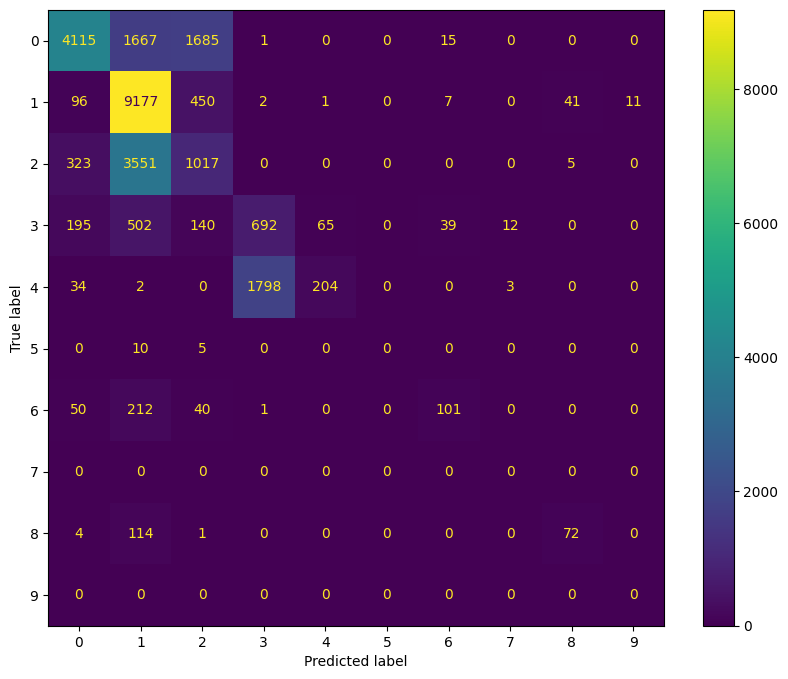

In [58]:
#Plotando a matriz de confusão

fig,axes = plt.subplots(figsize=(10,8))

#disp = ConfusionMatrixDisplay(confusion_matrix(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind),
                            #   display_labels=list(dic_blind.values()))

disp = ConfusionMatrixDisplay(confusion_matrix(blind['FORCE_2020_LITHOFACIES_LITHOLOGY'],y_blind))

disp.plot(ax=axes)

#axes.set_xticklabels(dic_blind.values(),rotation=90)

fig.show()

In [59]:
#usando o map para transform as labels em strings
dataset['mlp'] = list(map(litologia_dict.get,mlp.predict(scaler.transform(X))))
blind['mlp'] = list(map(litologia_dict.get,y_blind))

In [60]:
@interact(well=blind.WELL.unique())
def update_well_plot(well):
    plot_well_logs_comparison(blind, well=well,lithology_col='LITHOLOGY',predicted_col='mlp',colors=colors,lithology=lithology,dz=100)

interactive(children=(Dropdown(description='well', options=('25/5-1', '25/9-1', '31/4-5', '35/11-1', '7/1-1'),…